In [2]:
# preprocessing data 
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd

# import training and testing dataset
train_data = pd.read_csv('/content/drive/MyDrive/UNSW/UNSW_NB15_training-set.csv')

test_data = pd.read_csv('/content/drive/MyDrive/UNSW/UNSW_NB15_testing-set.csv')

#%%
y_train = train_data.label.to_frame()
features = [c for c in train_data.columns if (c != "label") and (c != "id")]
X_train = train_data[features]

y_test = test_data.label.to_frame()
features = [c for c in test_data.columns if (c != "label") and (c != "id")]
X_test = test_data[features]

#%%
# feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train.iloc[:,:] = scaler.fit_transform(X_train.to_numpy())
X_test.iloc[:,:] = scaler.transform(X_test.to_numpy())

from tensorflow.keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model 
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# predict test set resutl and make confusion matrix
y_pred = loaded_model.predict(X_test)
y_pred_binary = (y_pred > 0.5)
from sklearn.metrics import confusion_matrix

def get_confusion_matrix_values(z_true, z_pred):
    cm = confusion_matrix(z_true, z_pred)
    return(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

TP, FP, FN, TN = get_confusion_matrix_values(y_test, y_pred_binary)
detection_rate = TP/(TP+FN)
false_alarm_rate = FP/(TN+FP)
accuracy = (TP+TN)/(TP+FP+TN+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = (2*precision*recall)/(precision + recall)

print("\n Detection rate = ", detection_rate, "\n")
print("False alarm rate = ", false_alarm_rate, "\n")
print("Accuracy = ", accuracy, "\n")
print("Precision = ", precision, "\n")
print("Recall = ", recall, "\n")
print("F1 = ", F1, "\n")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Loaded model from disk

 Detection rate =  0.9749285033365109 

False alarm rate =  0.12423813456018246 

Accuracy =  0.913666618082884 

Precision =  0.8292162162162162 

Recall =  0.9749285033365109 

F1 =  0.8961881115817146 



In [3]:
#%%
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import accuracy_score

def score(self, X, y, sample_weight=None):
      return accuracy_score(y, self.predict(X)>0.5, sample_weight=sample_weight)

perm = PermutationImportance(loaded_model, score, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

     |████████████████████████████████| 112kB 6.2MB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.0896 ± 0.0015,sttl
0.0868 ± 0.0009,ct_dst_src_ltm
0.0847 ± 0.0015,dttl
0.0521 ± 0.0006,xProt
0.0428 ± 0.0006,xServ
0.0365 ± 0.0005,tcprtt
0.0337 ± 0.0018,ct_srv_dst
0.0310 ± 0.0005,ct_state_ttl
0.0268 ± 0.0004,ct_src_dport_ltm
0.0231 ± 0.0012,ct_dst_sport_ltm


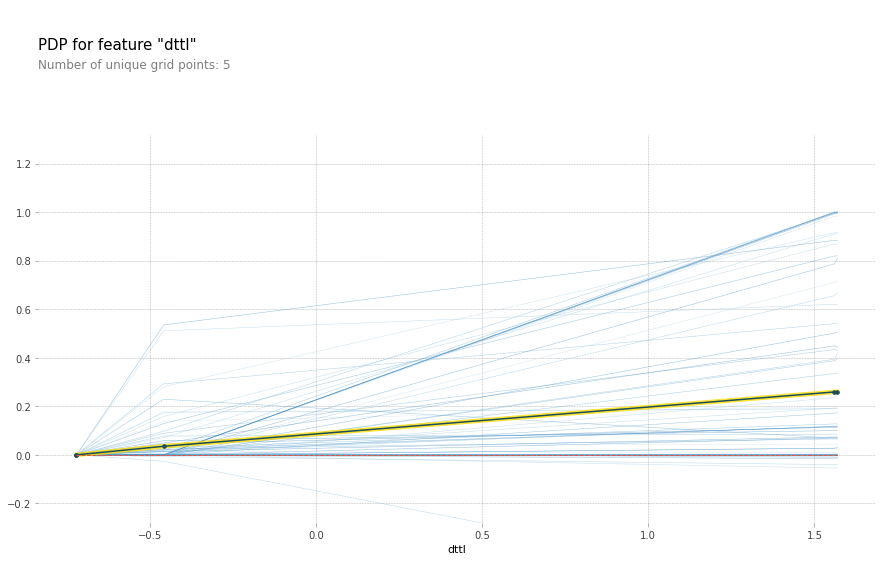

In [6]:
#%%
from matplotlib import pyplot as plt
!pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots

feature_name = "dttl"
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=loaded_model, dataset=X_test, model_features=X_test.columns, 
                            feature=feature_name)

# plot it
pdp.pdp_plot(pdp_goals, feature_name, plot_lines=True, frac_to_plot=100)
plt.show()

     |████████████████████████████████| 358kB 6.7MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491637 sha256=f1cbcdb6c2a4c78692f6e236cfab192cd08876a2a6ec451dd9122e61c2b77415
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


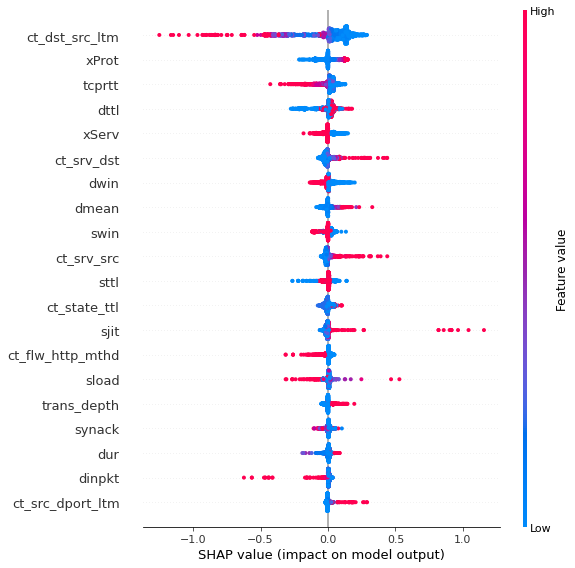

In [7]:
#%%
!pip install shap
import shap
import pandas as pd 

sample = X_test.iloc[:2000]
 
explainer = shap.DeepExplainer(loaded_model, np.array(sample))
shap_values = explainer.shap_values(np.array(sample))

shap.initjs()
#force_plot = shap.force_plot(explainer.expected_value[0].numpy().tolist(), shap_values[0], sample)
shap.summary_plot(shap_values[0], sample)

In [8]:
#%%
import shap  # package used to calculate Shap values

index = 100
row_to_show = X_test.iloc[index:index+1]
print(loaded_model.predict(row_to_show))
shap_values = explainer.shap_values(np.array(row_to_show))
print('shap_values: ', shap_values[0])
print('explainer ', explainer.expected_value[0].numpy().tolist())
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy().tolist(), shap_values[0], row_to_show) 

[[3.0802268e-05]]
shap_values:  [[ 3.23310651e-03 -1.00088702e-01 -7.78209881e-02 -1.10504811e-02
  -3.58287322e-05 -3.57971370e-03 -8.32310644e-04  1.61056788e-03
   2.09125455e-02  7.96243531e-03 -1.78088568e-01 -3.75241521e-02
   7.53957023e-04 -1.55107770e-03  8.00237988e-04 -1.55197576e-02
   5.80846252e-03 -2.04049968e-03 -7.34331058e-03 -9.80680889e-02
   2.89777105e-03  4.88038109e-03  2.03598382e-02  1.78660630e-02
   5.28128821e-03 -3.30395450e-03 -3.57605852e-02 -5.98647656e-02
  -7.45022117e-03 -1.27351236e-03  3.21688520e-02 -1.46409718e-02
   2.88281186e-04  2.51896277e-04  7.04167821e-04 -3.31100107e-01
  -5.24945888e-03  1.48482542e-03  1.46245828e-02  6.12108880e-04
   4.92503936e-02  7.60147546e-08]]
explainer  0.8004660606384277
